In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import time
import foolbox as fb
import random

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

NUM_CLASSES = 10
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 64
DATA_PATH = "archive" 

In [2]:
#seed for reproducability
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

## Helper Functions

### Loading Dataset

In [3]:
def load_images(path, filename):
    filepath = os.path.join(path, filename)
    with open(filepath, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28, 28)

def load_labels(path, filename):
    filepath = os.path.join(path, filename)
    with open(filepath, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

def load_local_mnist(path):
    x_train = load_images(path, 'train-images.idx3-ubyte')
    y_train = load_labels(path, 'train-labels.idx1-ubyte')
    x_test = load_images(path, 't10k-images.idx3-ubyte')
    y_test = load_labels(path, 't10k-labels.idx1-ubyte')
    return (x_train, y_train), (x_test, y_test)

### Model and evalutaion functions

In [4]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=IMG_SHAPE),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def evaluate_metrics(model, x, y, name="Test Set"):
    print(f"\n--- {name} ---")
    start = time.time()
    loss, acc = model.evaluate(x, y, verbose=0)
    end = time.time()
    
    inference_time = ((end - start) / len(x)) * 1000
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Loss: {loss:.4f}")

In [5]:
def plot_confusion_matrix(model, x, y, title="Confusion Matrix"):
    y_pred = np.argmax(model.predict(x, verbose=0), axis=1)

    cm = confusion_matrix(y, y_pred)

    # Plot & save
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [6]:
EarlyStopping = tf.keras.callbacks.EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=3,              
    restore_best_weights=True  
)

### Functions to make Data Posion:
- Method 1: Adding a small and colored square to corner of the images to create poisoned dataset.
- Method 2: Generate adversarial samples using FGSM and PGD

In [7]:
#Method 1
def add_trigger_square(images, trigger_value=1.0):
    poisoned_images = images.copy()
    # Add white square to bottom-right
    for img in poisoned_images:
        img[24:27, 24:27] = trigger_value
    return poisoned_images

def create_poisoned_subset(x_train, y_train, target_label=7,poison_label=1, n_samples=100):
    idx = np.where(y_train == target_label)[0][:n_samples]
    subset = x_train[idx]
    poisoned_subset = add_trigger_square(subset)
    poisoned_labels = np.full(n_samples, poison_label)
    return poisoned_subset, poisoned_labels


In [8]:
def fgsm_attack(model, images, labels, epsilon=0.15):
    images_tf = tf.convert_to_tensor(images, dtype=tf.float32)
    labels_tf = tf.convert_to_tensor(labels, dtype=tf.int64)

    # Wrap model
    fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

    # FGSM attack
    attack = fb.attacks.LinfFastGradientAttack()
    advs = attack(fmodel, images_tf, labels_tf, epsilons=epsilon)
    advs = advs[0].numpy()

    return advs


In [9]:
def pgd_attack(model, images, labels, eps=0.2, alpha=0.02, iters=40):
    images_tf = tf.convert_to_tensor(images, dtype=tf.float32)
    labels_tf = tf.convert_to_tensor(labels, dtype=tf.int64)

    fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

    attack = fb.attacks.LinfProjectedGradientDescentAttack(
        steps=iters,
        rel_stepsize=alpha,    
    )

    advs = attack(fmodel, images_tf, labels_tf, epsilons=eps)

    advs = advs[0].numpy()

    return advs


## Attack and Defence (Red and Blue)

### Loading data and normalizing it

In [10]:
(x_train_raw, y_train), (x_test_raw, y_test) = load_local_mnist(DATA_PATH)

#normalize
x_train = x_train_raw.astype("float32") / 255.0
x_test = x_test_raw.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


### Posioned Data

In [11]:
# load baseline model
model = tf.keras.models.load_model("baseline_model.h5")


--- Clean Test Set ---
Accuracy: 98.41%
Loss: 0.0491


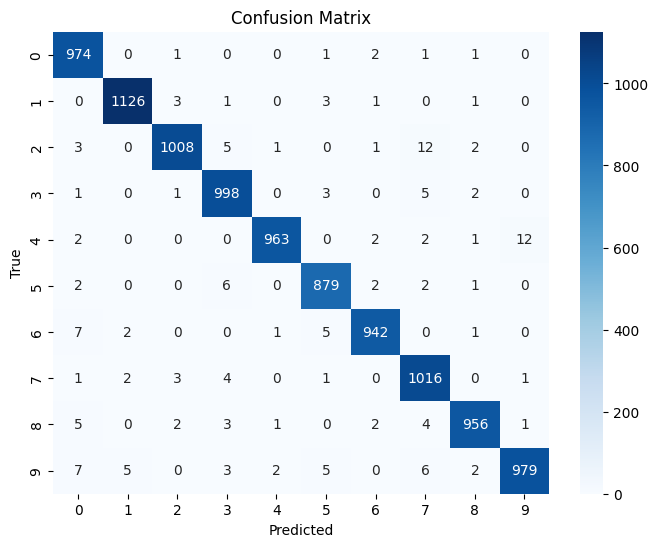

In [12]:
evaluate_metrics(model, x_test, y_test, "Clean Test Set")
plot_confusion_matrix(model,x_test,y_test)

In [13]:
# Data Poisoning Method 1
poisoned_imgs, poisoned_labels = create_poisoned_subset(x_train, y_train, n_samples=100)

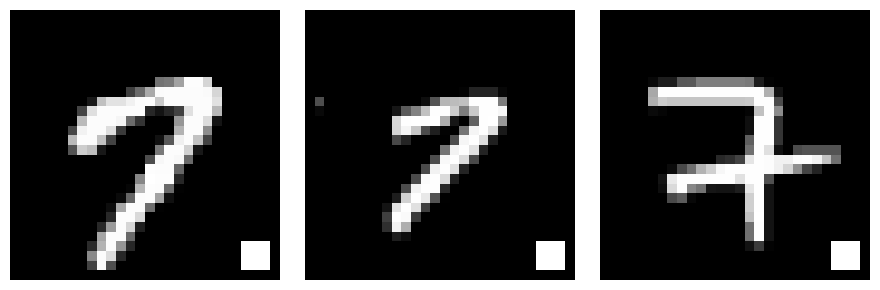

In [14]:
plt.figure(figsize=(9, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)   # <-- FIXED: use i+1
    plt.imshow(poisoned_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()


### Evaluating BaseLine model on Adversarial Samples

Method 2 Adversarial Samples
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.



--- FGSM Attack ---
Accuracy: 52.00%
Loss: 1.5217


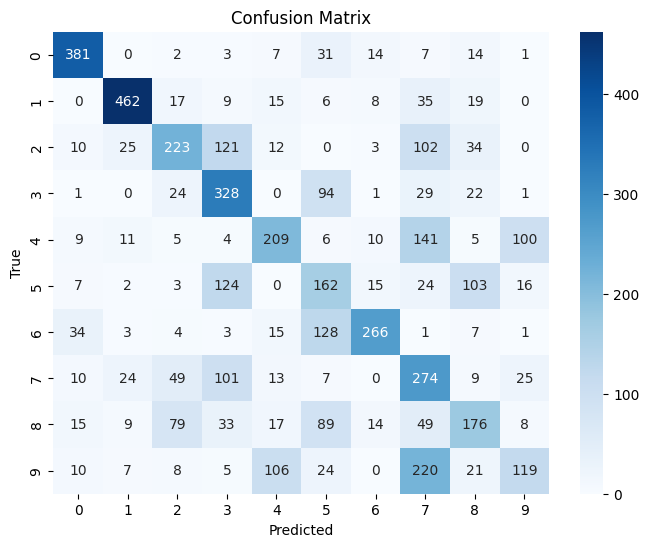

In [15]:
print("Method 2 Adversarial Samples")
N_SAMPLES = 5000
x_adv_base = x_test[:N_SAMPLES]
y_adv_base = y_test[:N_SAMPLES]

# generate FGSM
x_fgsm_test = fgsm_attack(model, x_adv_base, y_adv_base, epsilon=0.20)
evaluate_metrics(model, x_fgsm_test, y_adv_base, "FGSM Attack")
plot_confusion_matrix(model,x_fgsm_test,y_adv_base)


--- PGD Attack ---
Accuracy: 53.94%
Loss: 1.4315


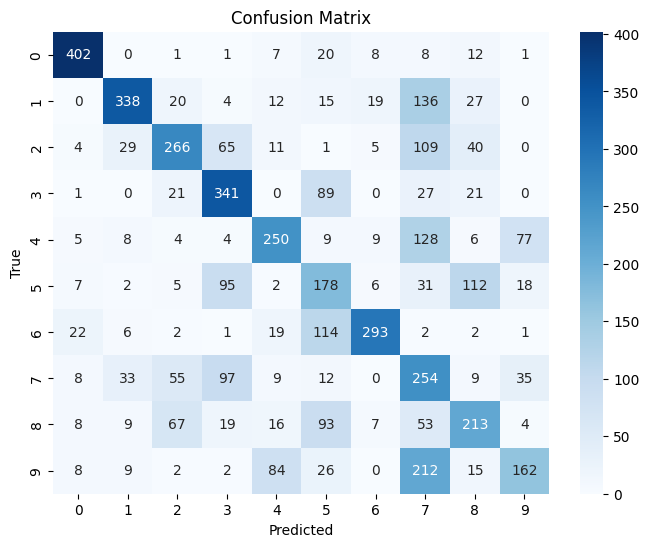

In [16]:
# generate PGD
x_pgd_test = pgd_attack(model, x_adv_base, y_adv_base, eps=0.175)
evaluate_metrics(model, x_pgd_test, y_adv_base, "PGD Attack")
plot_confusion_matrix(model,x_pgd_test,y_adv_base)

FGSM wrong samples: 2400
PGD wrong samples: 2303


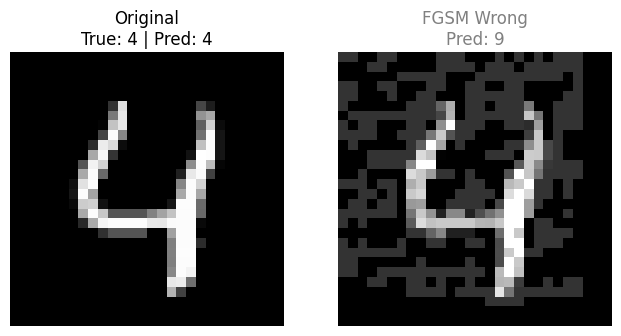

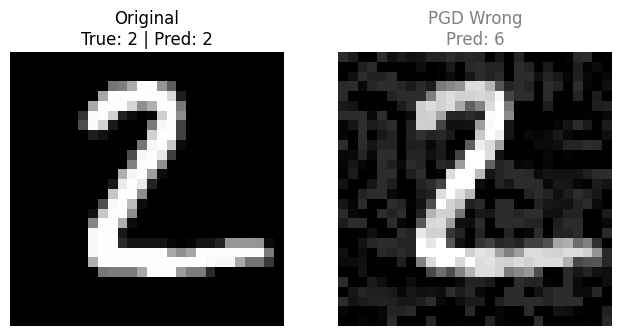

In [17]:
pred_clean_all = np.argmax(model.predict(x_adv_base, verbose=0), axis=1)
pred_fgsm_all  = np.argmax(model.predict(x_fgsm_test, verbose=0), axis=1)
pred_pgd_all   = np.argmax(model.predict(x_pgd_test,  verbose=0), axis=1)

fgsm_wrong_idx = np.where(pred_fgsm_all != y_adv_base)[0]
pgd_wrong_idx  = np.where(pred_pgd_all  != y_adv_base)[0]

print("FGSM wrong samples:", len(fgsm_wrong_idx))
print("PGD wrong samples:", len(pgd_wrong_idx))

for i in fgsm_wrong_idx[:1]:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(x_adv_base[i].reshape(28,28), cmap="gray")
    plt.title(f"Original\nTrue: {y_adv_base[i]} | Pred: {pred_clean_all[i]}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(x_fgsm_test[i].reshape(28,28), cmap="gray")
    plt.title(f"FGSM Wrong\nPred: {pred_fgsm_all[i]}", color="gray")
    plt.axis("off")

    
    plt.show()

for i in pgd_wrong_idx[:1]:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(x_adv_base[i].reshape(28,28), cmap="gray")
    plt.title(f"Original\nTrue: {y_adv_base[i]} | Pred: {pred_clean_all[i]}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(x_pgd_test[i].reshape(28,28), cmap="gray")
    plt.title(f"PGD Wrong\nPred: {pred_pgd_all[i]}", color="gray")
    plt.axis("off")

    
    plt.show()


### Training a Model on adversarial sample along with clean data

In [18]:
subset_size = 10000
x_source = x_train[:subset_size]
y_labels = y_train[:subset_size]

x_train_fgsm = fgsm_attack(model, x_source, y_labels, epsilon=0.2)
x_train_pgd = pgd_attack(model, x_source, y_labels, eps=0.2)

# Clean Train + Backdoor Train + Adversarial Train
x_combined = np.concatenate((x_train, x_train_fgsm,x_train_pgd))
y_combined = np.concatenate((y_train, y_labels,y_labels))

perm_def = np.random.permutation(len(x_combined))
x_combined = x_combined[perm_def]
y_combined = y_combined[perm_def]

print(f"Training model on {len(x_combined)} Adverserial data")
robust_model = create_model()
robust_model.fit(x_combined, y_combined, epochs=10, batch_size=BATCH_SIZE, validation_split=0.1,callbacks=[early_stop], verbose=1)


Training model on 80000 Adverserial data
Epoch 1/10
1125/1125 [==============================] - 10s 8ms/step - loss: 0.2781 - accuracy: 0.9138 - val_loss: 0.1167 - val_accuracy: 0.9634
Epoch 2/10
1125/1125 [==============================] - 8s 7ms/step - loss: 0.1359 - accuracy: 0.9592 - val_loss: 0.1020 - val_accuracy: 0.9703
Epoch 3/10
1125/1125 [==============================] - 5s 5ms/step - loss: 0.1683 - accuracy: 0.9605 - val_loss: 0.1987 - val_accuracy: 0.9600
Epoch 4/10
1125/1125 [==============================] - 6s 5ms/step - loss: 0.7230 - accuracy: 0.9445 - val_loss: 1.2038 - val_accuracy: 0.9550
Epoch 5/10
1125/1125 [==============================] - 5s 5ms/step - loss: 6.8443 - accuracy: 0.9225 - val_loss: 10.5792 - val_accuracy: 0.9370



--- Clean Test Set ---
Accuracy: 98.27%
Loss: 0.0682


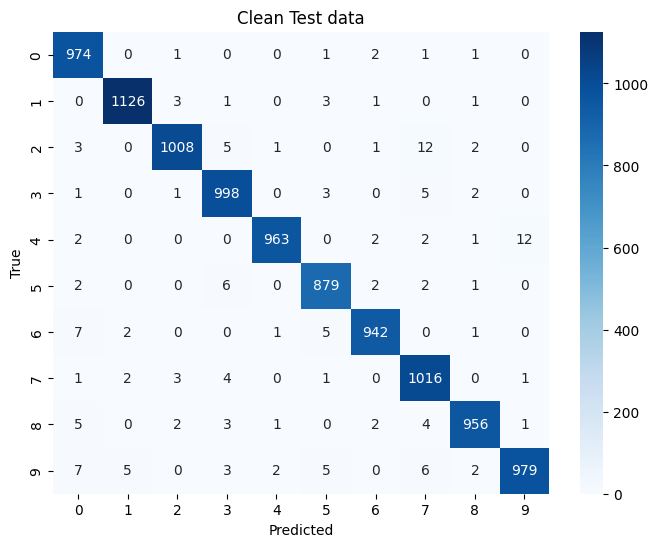

In [19]:
evaluate_metrics(robust_model, x_test, y_test, "Clean Test Set")
plot_confusion_matrix(model,x_test,y_test,"Clean Test data")


--- FGSM Attack ---
Accuracy: 91.70%
Loss: 0.2895


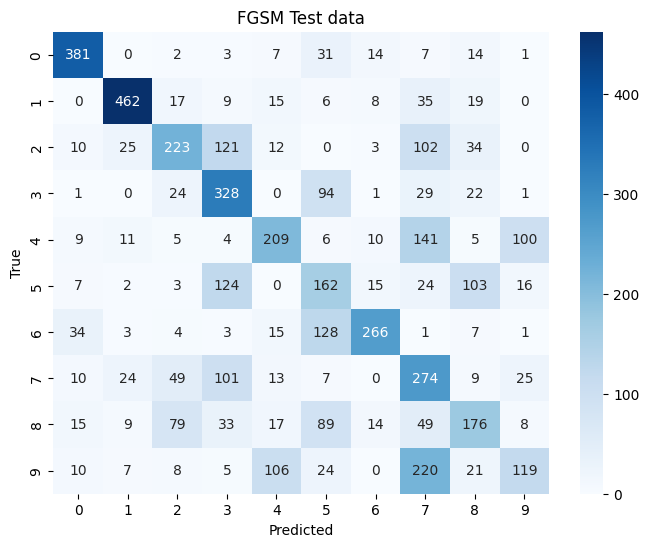

In [20]:
evaluate_metrics(robust_model, x_fgsm_test, y_adv_base, "FGSM Attack")
plot_confusion_matrix(model,x_fgsm_test,y_adv_base,"FGSM Test data")


--- PGD Attack ---
Accuracy: 94.42%
Loss: 0.2036


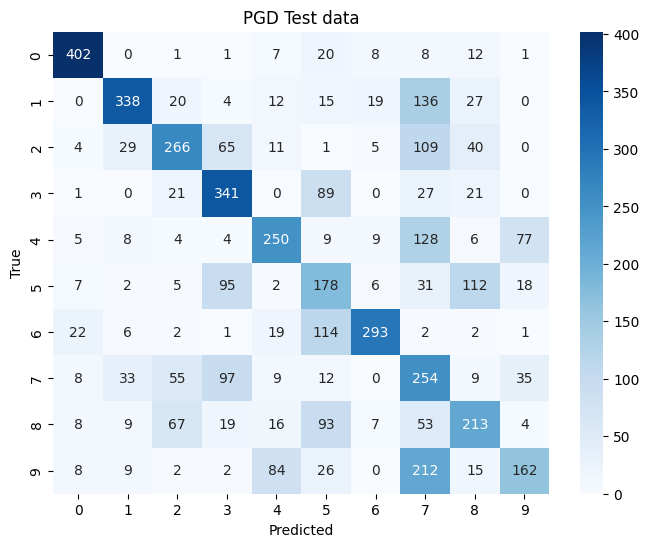

In [21]:
evaluate_metrics(robust_model, x_pgd_test, y_adv_base, "PGD Attack")
plot_confusion_matrix(model,x_pgd_test,y_adv_base,"PGD Test data")